# Neural Networks

Neural networks are a way of parametrizing non-linear functions. On a very basic level, they are formed by a composition of non-linear function. The functions is defined with a layered architecture. The mapping from the input layer to the output layer is performed via hidden layers. Each layer $k$ produces an output $z_k$ that is a non-linear function of a weighted combination of the outputs of the previous layer, $z_k = g_k(W_k z_{k-1})$. 

Once the architecture and the activation functions $g_k(\cdot)$ are defined, the weights $W_k$ are trained. If all the functions $g_k$ are (sub)-differentiable then, via the chain rule, gradients exist and can be computed. The weights are trained via different variants of gradient descent. 

In [1]:
import numpy as np 
import matplotlib as mpl 
import matplotlib.pyplot as plt 

from sklearn import cluster, datasets, mixture
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.model_selection import train_test_split

import ipywidgets
from ipywidgets import interact, interactive, interact_manual, fixed
import IPython
from utilities import plot_helpers


%matplotlib inline
%load_ext autoreload
%autoreload 2
from matplotlib import rcParams
rcParams['figure.figsize'] = (10, 5)  # Change this if figures look ugly. 
rcParams['font.size'] = 16

import warnings
warnings.filterwarnings("ignore")

## Classification Demo

Neural network training has a lot of hyperparameters. Architecture, learning rate, batch size, optimization algorithm, random seed are just a few of them. Because of non-convexity, 

In [2]:
n_samples = 200

rcParams['figure.figsize'] = (10, 5)  # Change this if figures look ugly. 
rcParams['font.size'] = 16
def mlp(dataset, hidden_layer_sizes, activation, solver, reg, noise):
    np.random.seed(42)
    classifier = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, 
                               activation=activation,
                               solver=solver,
#                                max_iter=n_iter, 
                               alpha=np.power(10., reg),
#                                verbose=10, 
#                                tol=1e-4, 
                               random_state=1,
                               learning_rate_init=.1)

    if dataset is 'blobs':
        X, Y = datasets.make_blobs(n_samples=n_samples, centers=2, random_state=3, cluster_std=10*noise)
    elif dataset is 'circles':
        X, Y = datasets.make_circles(n_samples=n_samples, factor=.5, noise=noise, random_state=42)
    elif dataset is 'moons':
        X, Y = datasets.make_moons(n_samples=n_samples, noise=noise, random_state=42)
    elif dataset == 'xor':
        np.random.seed(42)
        step = int(n_samples/4)
        
        X = np.zeros((n_samples, 2))
        Y = np.zeros(n_samples)
        
        X[0*step:1*step, :] = noise * np.random.randn(step, 2)
        Y[0*step:1*step] = 1
        X[1*step:2*step, :] = np.array([1, 1]) + noise * np.random.randn(step, 2)
        Y[1*step:2*step] = 1
        
        X[2*step:3*step, :] = np.array([0, 1]) + noise * np.random.randn(step, 2)
        Y[2*step:3*step] = -1
        X[3*step:4*step, :] = np.array([1, 0]) + noise * np.random.randn(step, 2)
        Y[3*step:4*step] = -1
    
    elif dataset == 'periodic':
        
        step = int(n_samples/4)
        
        X = np.zeros((n_samples, 2))
        Y = np.zeros(n_samples)
        
        X[0*step:1*step, :] = noise * np.random.randn(step, 2)
        Y[0*step:1*step] = 1
        X[1*step:2*step, :] = np.array([0, 2]) + noise * np.random.randn(step, 2)
        Y[1*step:2*step] = 1
        
        X[2*step:3*step, :] = np.array([0, 1]) + noise * np.random.randn(step, 2)
        Y[2*step:3*step] = -1
        X[3*step:4*step, :] = np.array([0, 3]) + noise * np.random.randn(step, 2)
        Y[3*step:4*step] = -1
    
    X = X[Y <= 1, :]
    Y = Y[Y <=1 ]
    Y[Y==0] = -1
        
    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=.4)
    
    classifier.fit(X_train, y_train)
    print(classifier.score(X_test, y_test))
    
    
    # plot the line, the points, and the nearest vectors to the plane
    plt.figure()
    plt.clf()
    fig = plt.axes()
    opt = {'marker': 'r*', 'label': '+'}
    plot_helpers.plot_data(X[np.where(Y == 1)[0], 0], X[np.where(Y == 1)[0], 1], fig=fig, options=opt)
    opt = {'marker': 'bs', 'label': '-'}
    plot_helpers.plot_data(X[np.where(Y == -1)[0], 0], X[np.where(Y == -1)[0], 1], fig=fig, options=opt)

    mins = np.min(X, 0)
    maxs = np.max(X, 0)
    x_min = mins[0] - 1
    x_max = maxs[0] + 1
    y_min = mins[1] - 1
    y_max = maxs[1] + 1

    XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]  
    Xplot = np.c_[XX.ravel(), YY.ravel()]
    if hasattr(classifier, "decision_function"):
        Z = classifier.decision_function(Xplot)
    else:
        Z = classifier.predict_proba(Xplot)[:, 1]
            
    # Put the result into a color plot
    Z = Z.reshape(XX.shape)
    # plt.figure(fignum, figsize=(4, 3))
    # Put the result into a color plot
    plt.contourf(XX, YY, Z, cmap=plt.cm.jet, alpha=.3)
    
    
interact(mlp, 
        dataset=['blobs', 'circles', 'moons', 'xor', 'periodic'],
        activation=['relu', 'logistic', 'identity', 'tanh'],
        solver=[ 'adam','lbfgs', 'sgd'],
        hidden_layer_sizes=[(4, ), (100, ), (50, 50), (100, 100), (50, 50, 50), (100, 100, 100)],
        reg=ipywidgets.FloatSlider(value=-3,
                                    min=-3,
                                    max=3,
                                    step=0.1,
                                    readout_format='.1f',
                                    description='reg 10^:',
                                    style={'description_width': 'initial'},
                                    continuous_update=False),
        noise=ipywidgets.FloatSlider(value=0.05,
                                    min=0.01,
                                    max=0.3,
                                    step=0.01,
                                    readout_format='.2f',
                                    description='noise:',
                                    style={'description_width': 'initial'},
                                    continuous_update=False),  
        );

interactive(children=(Dropdown(description='dataset', options=('blobs', 'circles', 'moons', 'xor', 'periodic')…

interactive(children=(Dropdown(description='dataset', options=('blobs', 'circles', 'moons', 'xor', 'periodic')…

# Pytorch Demo

## Define Models

In [3]:
import torch 
import torch.nn as nn 
import torch.optim as optim 
import torchvision
from torchvision import transforms

class FeedForwardNetwork(nn.Module):
    def __init__(self, dropout=True):
        """Here you define the network."""
        super().__init__()
        self.fc1 = nn.Sequential(nn.Linear(28 * 28, 100), nn.ReLU())
        self.fc2 = nn.Sequential(nn.Linear(100, 100), nn.ReLU())
        if dropout:
            self.fc3 = nn.Sequential(nn.Dropout(), nn.Linear(100, 10))
        else:
            self.fc3 = nn.Linear(100, 10)
            
    
    def forward(self, x):
        """Here you compute the forwards pass."""
        x = x.view(-1, 28 * 28)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x 
    
class ConvolutionalNetwork(nn.Module):
    def __init__(self, dropout=True):
        """Here you define the network."""
        super().__init__()
        
        self.c1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(6),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride=2)
        )
        self.c2 = nn.Sequential(
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        
        self.fc1 = nn.Sequential(nn.Linear(256, 120), nn.ReLU())
        self.fc2 = nn.Sequential(nn.Linear(120, 84), nn.ReLU())
        if dropout:
            self.fc3 = nn.Sequential(nn.Dropout(), nn.Linear(84, 10))
        else:
            self.fc3 = nn.Linear(84, 10)
            
    def forward(self, x):
        """Here you compute the forwards pass."""
        x = self.c1(x)
        x = self.c2(x)
        x = x.view(-1, 256)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x 
    

## Define datasets

In [4]:
batch_size = 128 
# torchvision.datasets.MNIST.resources = [
#             ('https://ossci-datasets.s3.amazonaws.com/mnist/train-images-idx3-ubyte.gz', 'f68b3c2dcbeaaa9fbdd348bbdeb94873'),
#             ('https://ossci-datasets.s3.amazonaws.com/mnist/train-labels-idx1-ubyte.gz', 'd53e105ee54ea40749a09fcbcd1e9432'),
#             ('https://ossci-datasets.s3.amazonaws.com/mnist/t10k-images-idx3-ubyte.gz', '9fb629c4189551a2d022fa330f9573f3'),
#             ('https://ossci-datasets.s3.amazonaws.com/mnist/t10k-labels-idx1-ubyte.gz', 'ec29112dd5afa0611ce80d1b7f02629c')
#         ]

t2pil = transforms.ToPILImage()
tranforms_ = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5, ))])
train_set = torchvision.datasets.MNIST('../data', train=True, download=True, transform=tranforms_)
test_set = torchvision.datasets.MNIST('../data', train=False, download=True, transform=tranforms_)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)


## Train! 

In [5]:
rcParams['figure.figsize'] = (20, 10)


def compute_accuracy(output, true_label):
    return (output.argmax(-1) == true_label).double().mean()

def evaluate_step(network, criterion, data, target):
    output = network(data)
    loss = criterion(output, target)
    accuracy = compute_accuracy(output, target)
    return loss.item(), accuracy.item()

def train_step(network, criterion, optimizer, data, target):
    optimizer.zero_grad()
    output = network(data)
    loss = criterion(output, target)
    loss.backward()
    optimizer.step()
    accuracy = compute_accuracy(output, target)
    return loss.item(), accuracy.item()
        
def evaluate_epoch(network, data_loader, criterion):
    network.eval()
    losses = []
    accuracies = []
    for data, target in test_loader:
        loss, accuracy = evaluate_step(network, criterion, data, target)
        losses.append(loss)
        accuracies.append(accuracy)
    losses = torch.tensor(losses)
    accuracies = torch.tensor(accuracies)
    return losses.mean(), accuracies.mean()

def plot_losses(x_train, train_losses, x_test, test_losses, ax):
    ax.plot(x_train, train_losses, label="Train Loss")
    ax.plot(x_test, test_losses, label="Test Loss")
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Loss")
    ax.set_xlim([0, 2000])
    ax.set_ylim([0, 2.5])
    ax.legend(loc="north west")

    
def plot_accuracies(x_train, train_accuracies, x_test, test_accuracies, ax):
    ax.plot(x_train, train_accuracies, label="Train Accuracy")
    ax.plot(x_test, test_accuracies, label="Test Accuracy")
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Accuracy")
    ax.set_xlim([0, 2000])
    ax.set_ylim([0, 1.0])
    ax.legend(loc="north west")
    
def resample(network, dataloader, ax_image, ax_labels):
    for data, label in dataloader:
        break 
    idx = np.random.randint(data.shape[0])
    im = data[idx]
    true_label = label[idx]
    out = network(data)[idx]
    ax_image.imshow(t2pil(im), cmap='Greys')
    ax_image.set_xticklabels("")
    ax_image.set_yticklabels("")

    ax_labels.bar(np.arange(0, 10), nn.functional.softmax(out).detach().numpy())
    ax_labels.set_xticks(np.arange(0, 10))
    ax_labels.set_xticklabels(np.arange(0, 10))
    ax_labels.set_xlabel("Label")
    ax_labels.set_ylabel("Probability")
    ax_labels.set_ylim([0, 1])
    ax_labels.set_title(f"True Label: {true_label}")

def train_interactive(learning_rate, network, dropout):
    iteration = 0 
    x_train = []
    x_test = []
    momentum = 0.001
    num_epochs = 5

    train_losses, test_losses = [], []
    train_accuracies, test_accuracies = [], []
    if network == "FeedForward":
        network = FeedForwardNetwork(dropout)
    else:
        network = ConvolutionalNetwork(dropout)
    optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
    criterion = nn.CrossEntropyLoss()
    
    try:
        for epoch in range(num_epochs):
            with torch.no_grad():
                loss, accuracy = evaluate_epoch(network, test_loader, criterion)
                test_losses.append(loss)
                test_accuracies.append(accuracy)
                x_test.append(iteration)

            for data, target in train_loader:
                network.train()
                loss, accuracy = train_step(network, criterion, optimizer, data, target)
                train_losses.append(loss)
                train_accuracies.append(accuracy)
                x_train.append(iteration)

                if ((iteration + 1) % 200) == 0:
                    IPython.display.clear_output(wait=True)
                    plt.close()
                    epoch_str = f"epoch [{epoch + 1}/{num_epochs}], iter {iteration + 1}"
                    train_str = f"train loss:{loss:.4f}, train accuracy:{accuracy:.4f}"
                    test_str = f"test loss:{test_losses[-1]:.4f}, test accuracy:{test_accuracies[-1]:.4f}"
                    print(f"{epoch_str}, {train_str}, {test_str}")
                    fig, ax = plt.subplots(2,2)
                    ax_losses = ax[1, 0]
                    ax_accuracies = ax[1, 1]
                    ax_image = ax[0, 0]
                    ax_labels = ax[0, 1]

                    plot_losses(x_train, train_losses, x_test, test_losses, ax_losses)
                    plot_accuracies(x_train, train_accuracies, x_test, test_accuracies, ax_accuracies)
                    resample(network, test_loader, ax_image, ax_labels)

                    plt.show()

                iteration += 1
                
    except KeyboardInterrupt:
        pass
        
    with torch.no_grad():
        loss, accuracy = evaluate_epoch(network, test_loader, criterion)
        test_losses.append(loss)
        test_accuracies.append(accuracy)
        x_test.append(iteration)

    IPython.display.clear_output(wait=True)
    plt.close()
    epoch_str = f"epoch [{epoch + 1}/{num_epochs}], iter {iteration + 1}"
    train_str = f"train loss:{loss:.4f}, train accuracy:{accuracy:.4f}"
    test_str = f"test loss:{test_losses[-1]:.4f}, test accuracy:{test_accuracies[-1]:.4f}"
    print(f"{epoch_str}, {train_str}, {test_str}")
    fig, ax = plt.subplots(2,2)
    ax_losses = ax[1, 0]
    ax_accuracies = ax[1, 1]
    ax_image = ax[0, 0]
    ax_labels = ax[0, 1]

    plot_losses(x_train, train_losses, x_test, test_losses, ax_losses)
    plot_accuracies(x_train, train_accuracies, x_test, test_accuracies, ax_accuracies)
    resample(network, test_loader, ax_image, ax_labels)

    plt.show()
            
interact_manual(
    train_interactive, 
    learning_rate=ipywidgets.FloatLogSlider(value=0.01, min=-5, max=0), 
    network=["FeedForward", "Convolutional"],
    dropout=True);


interactive(children=(FloatLogSlider(value=0.01, description='learning_rate', max=0.0, min=-5.0), Dropdown(des…

interactive(children=(FloatLogSlider(value=0.01, description='learning_rate', max=0.0, min=-5.0), Dropdown(des…

# Universal function Aproximator

In [6]:
rcParams['figure.figsize'] = (20, 5)
from sklearn import svm
import IPython 
def laplacian_kernel(X, Y, bw):
    rows = X.shape[0]
    cols = Y.shape[0]
    K = np.zeros((rows, cols))
    for col in range(cols):
        dist = bw * np.linalg.norm(X - Y[col, :], ord=1, axis=1)
        K[:, col] = np.exp(-dist)
    return K

def process_regressor(regressor, xtrain, ytrain, xplot, yplot):
    regressor.fit(np.reshape(xtrain, (xtrain.size, 1)), ytrain)

    yhat = regressor.predict(np.reshape(xplot, (xplot.size, 1)))
    IPython.display.clear_output(wait=True)
    
    plt.scatter(xtrain, ytrain, label="Training data", alpha=0.2)
    plt.plot(xplot, yplot, 'r-', label="True Function")
    plt.plot(xplot, yhat, 'g-', label="Prediction")

    plt.legend(loc='lower center');
    plt.ylim([np.min(yplot)*1.1, np.max(yplot)*1.1])

def NNregressor(activation, solver, hidden_layer_size, reg, xtrain, ytrain, xplot, yplot):
    regressor = MLPRegressor(activation=activation,
                                 solver=solver,
                                 alpha=reg,
                                 random_state=0,
                                 hidden_layer_sizes=hidden_layer_size,
                                 tol=1e-6,
                                 max_iter=1000
                                )
    process_regressor(regressor, xtrain, ytrain, xplot, yplot)

def SVMregressor(kernel, bw, reg, xtrain, ytrain, xplot, yplot):
    if kernel == 'rbf':
        gamma = np.power(10., -bw)
        coef0 = 0
    elif kernel == 'laplacian':
        gamma = np.power(10., -bw)
        coef0 = 0
        kernel = lambda X, Y: laplacian_kernel(X, Y, gamma)
        
    regressor = svm.SVR(kernel=kernel, C=1./reg, gamma=gamma,coef0=coef0)
    process_regressor(regressor, xtrain, ytrain, xplot, yplot)

    
def uat_demo(function, n_samples, noise, family):
    if function == 1:
        f = lambda x: np.sin(x) 
    elif function == 2:
        f = lambda x: np.sin(x) * np.exp(np.abs(x))
    elif function == 3:
        f = lambda x: np.sin(x) * np.floor(np.abs(x))
    elif function == 4:
        f = lambda x: np.sin(x * np.floor(np.abs(x)))

    xmin = -6
    xmax = +6
    xplot = np.arange(xmin, xmax, 0.01)
    yplot = f(xplot)

    xtrain = xmin + (xmax -xmin) * np.random.rand(n_samples)
    ytrain = f(xtrain) + noise * np.random.randn(xtrain.size)
    
    plt.scatter(xtrain, ytrain, label="Training data", alpha=0.2)
    plt.plot(xplot, yplot, 'r-', label="True Function")

    plt.legend(loc='lower center');
    plt.ylim([np.min(yplot)*1.1, np.max(yplot)*1.1])
    plt.show()
    if family == 'NN':
        regressor = interact_manual(
            NNregressor,
            solver=['lbfgs', 'sgd', 'adam'],
            activation=['relu', 'identity', 'logistic'],
            hidden_layer_size=[(1,), (5, ), (50, ), (100, ), (1000, ),
                                   (5, 5, ), (50, 50, ), (100, 100), 
                                   (50, 50, 50), (100, 100, 100)],
            reg=[0, 10**-3, 10**-2, 10**-1, 1], 
            xtrain=fixed(xtrain), 
            ytrain=fixed(ytrain), 
            xplot=fixed(xplot), 
            yplot=fixed(yplot))
        
    elif family == 'SVM':
        regressor = interact_manual(
            SVMregressor,
            kernel=['rbf', 'laplacian'],
            bw=ipywidgets.FloatSlider(value=-1,
                                    min=-3,
                                    max=3,
                                    step=0.1,
                                    readout_format='.1f',
                                    description='Bandwidth 10^:',
                                    style={'description_width': 'initial'},
                                    continuous_update=False),
            reg=[10**-3, 10**-2, 10**-1, 1], 
            xtrain=fixed(xtrain), 
            ytrain=fixed(ytrain), 
            xplot=fixed(xplot), 
            yplot=fixed(yplot))

interact(uat_demo, 
                n_samples=[100, 200, 500, 1000, 10000],
                noise=[0, 0.01, 0.05, 0.1, 0.5,],
                function=ipywidgets.ToggleButtons(value=1, 
                                                  options=[1, 2, 3, 4], 
                                                  description='Function:',
                                                  style={'description_width': 'initial'}),
                family=['NN', 'SVM']
               );

# add plot of function as soon as the cell is run. 

interactive(children=(Dropdown(description='activation', options=('relu', 'identity', 'logistic'), value='relu…

interactive(children=(ToggleButtons(description='Function:', options=(1, 2, 3, 4), style=ToggleButtonsStyle(de…

interactive(children=(ToggleButtons(description='Function:', options=(1, 2, 3, 4), style=ToggleButtonsStyle(de…

## Stochastic Learning strategies

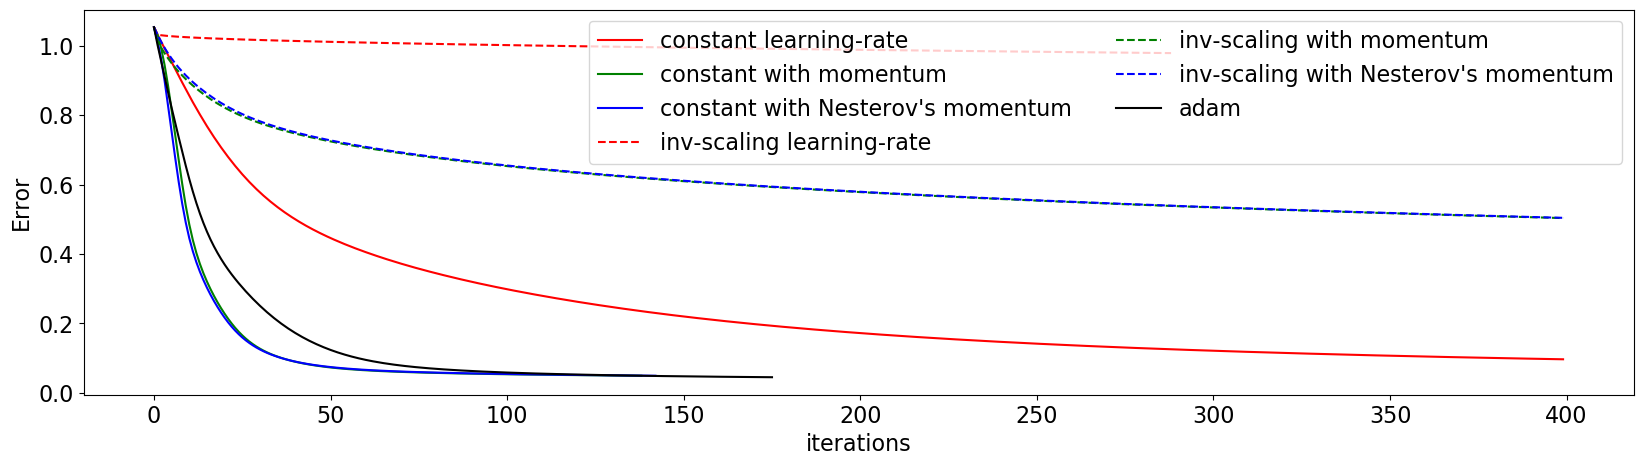

interactive(children=(Dropdown(description='dataset', options=('iris', 'digits', 'circles', 'moons'), value='i…

interactive(children=(Dropdown(description='dataset', options=('iris', 'digits', 'circles', 'moons'), value='i…

In [7]:
# different learning rate schedules and momentum parameters
params = [{'solver': 'sgd', 'learning_rate': 'constant', 'momentum': 0,
           'learning_rate_init': 0.2},
          {'solver': 'sgd', 'learning_rate': 'constant', 'momentum': .9,
           'nesterovs_momentum': False, 'learning_rate_init': 0.2},
          {'solver': 'sgd', 'learning_rate': 'constant', 'momentum': .9,
           'nesterovs_momentum': True, 'learning_rate_init': 0.2},
          {'solver': 'sgd', 'learning_rate': 'invscaling', 'momentum': 0,
           'learning_rate_init': 0.2},
          {'solver': 'sgd', 'learning_rate': 'invscaling', 'momentum': .9,
           'nesterovs_momentum': True, 'learning_rate_init': 0.2},
          {'solver': 'sgd', 'learning_rate': 'invscaling', 'momentum': .9,
           'nesterovs_momentum': False, 'learning_rate_init': 0.2},
          {'solver': 'adam', 'learning_rate_init': 0.01}]

labels = ["constant learning-rate", "constant with momentum",
          "constant with Nesterov's momentum",
          "inv-scaling learning-rate", "inv-scaling with momentum",
          "inv-scaling with Nesterov's momentum", "adam"]

plot_args = [{'c': 'red', 'linestyle': '-'},
             {'c': 'green', 'linestyle': '-'},
             {'c': 'blue', 'linestyle': '-'},
             {'c': 'red', 'linestyle': '--'},
             {'c': 'green', 'linestyle': '--'},
             {'c': 'blue', 'linestyle': '--'},
             {'c': 'black', 'linestyle': '-'}]

def plot_on_dataset(dataset):
    # Load datasets. 
    plt.figure()
    max_iter = 400
    if dataset == "iris":
        data = datasets.load_iris()
        X = data.data
        y = data.target
    elif dataset == "digits":
        data = datasets.load_digits()
        X = data.data
        y = data.target
        max_iter = 15
    elif dataset == "circles":
        X, y = datasets.make_circles(noise=0.2, factor=0.5, random_state=1)
    elif dataset == 'moons':
        X, y =  datasets.make_moons(noise=0.3, random_state=0)
    X = MinMaxScaler().fit_transform(X)
    
    # Train Classifiers.
    classifiers = []
    for label, param in zip(labels, params):
        classifier = MLPClassifier(verbose=0, 
                                    random_state=0,
                                    max_iter=max_iter, **param)
        classifier.fit(X, y)
        classifiers.append(classifier)
    for classifier, label, args in zip(classifiers, labels, plot_args):
            plt.plot(classifier.loss_curve_, label=label, **args)
            
    plt.legend(ncol=2, loc="best")
    plt.xlabel('iterations')
    plt.ylabel('Error')

interact(plot_on_dataset, dataset=['iris', 'digits', 'circles', 'moons']);